In [21]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


🔄 Inicializando análisis XAU/USD profesional...
📊 Temporalidades: ['1M', '15M']
                    ANÁLISIS INSTITUCIONAL XAU/USD                    
🔍 Símbolo: GC=F
⏱️  Temporalidades: 1M, 15M
⚙️  Parámetros:
   - Sensibilidad anomalías: Z > 2.8
   - Umbral inyección capital: 0.5%



Presiona Enter para generar el análisis... 



📊 Generando dashboard profesional...

⏳ Descargando datos 1m...
✅ Datos 1m obtenidos: 300 velas

⏳ Descargando datos 15m...
✅ Datos 15m obtenidos: 150 velas


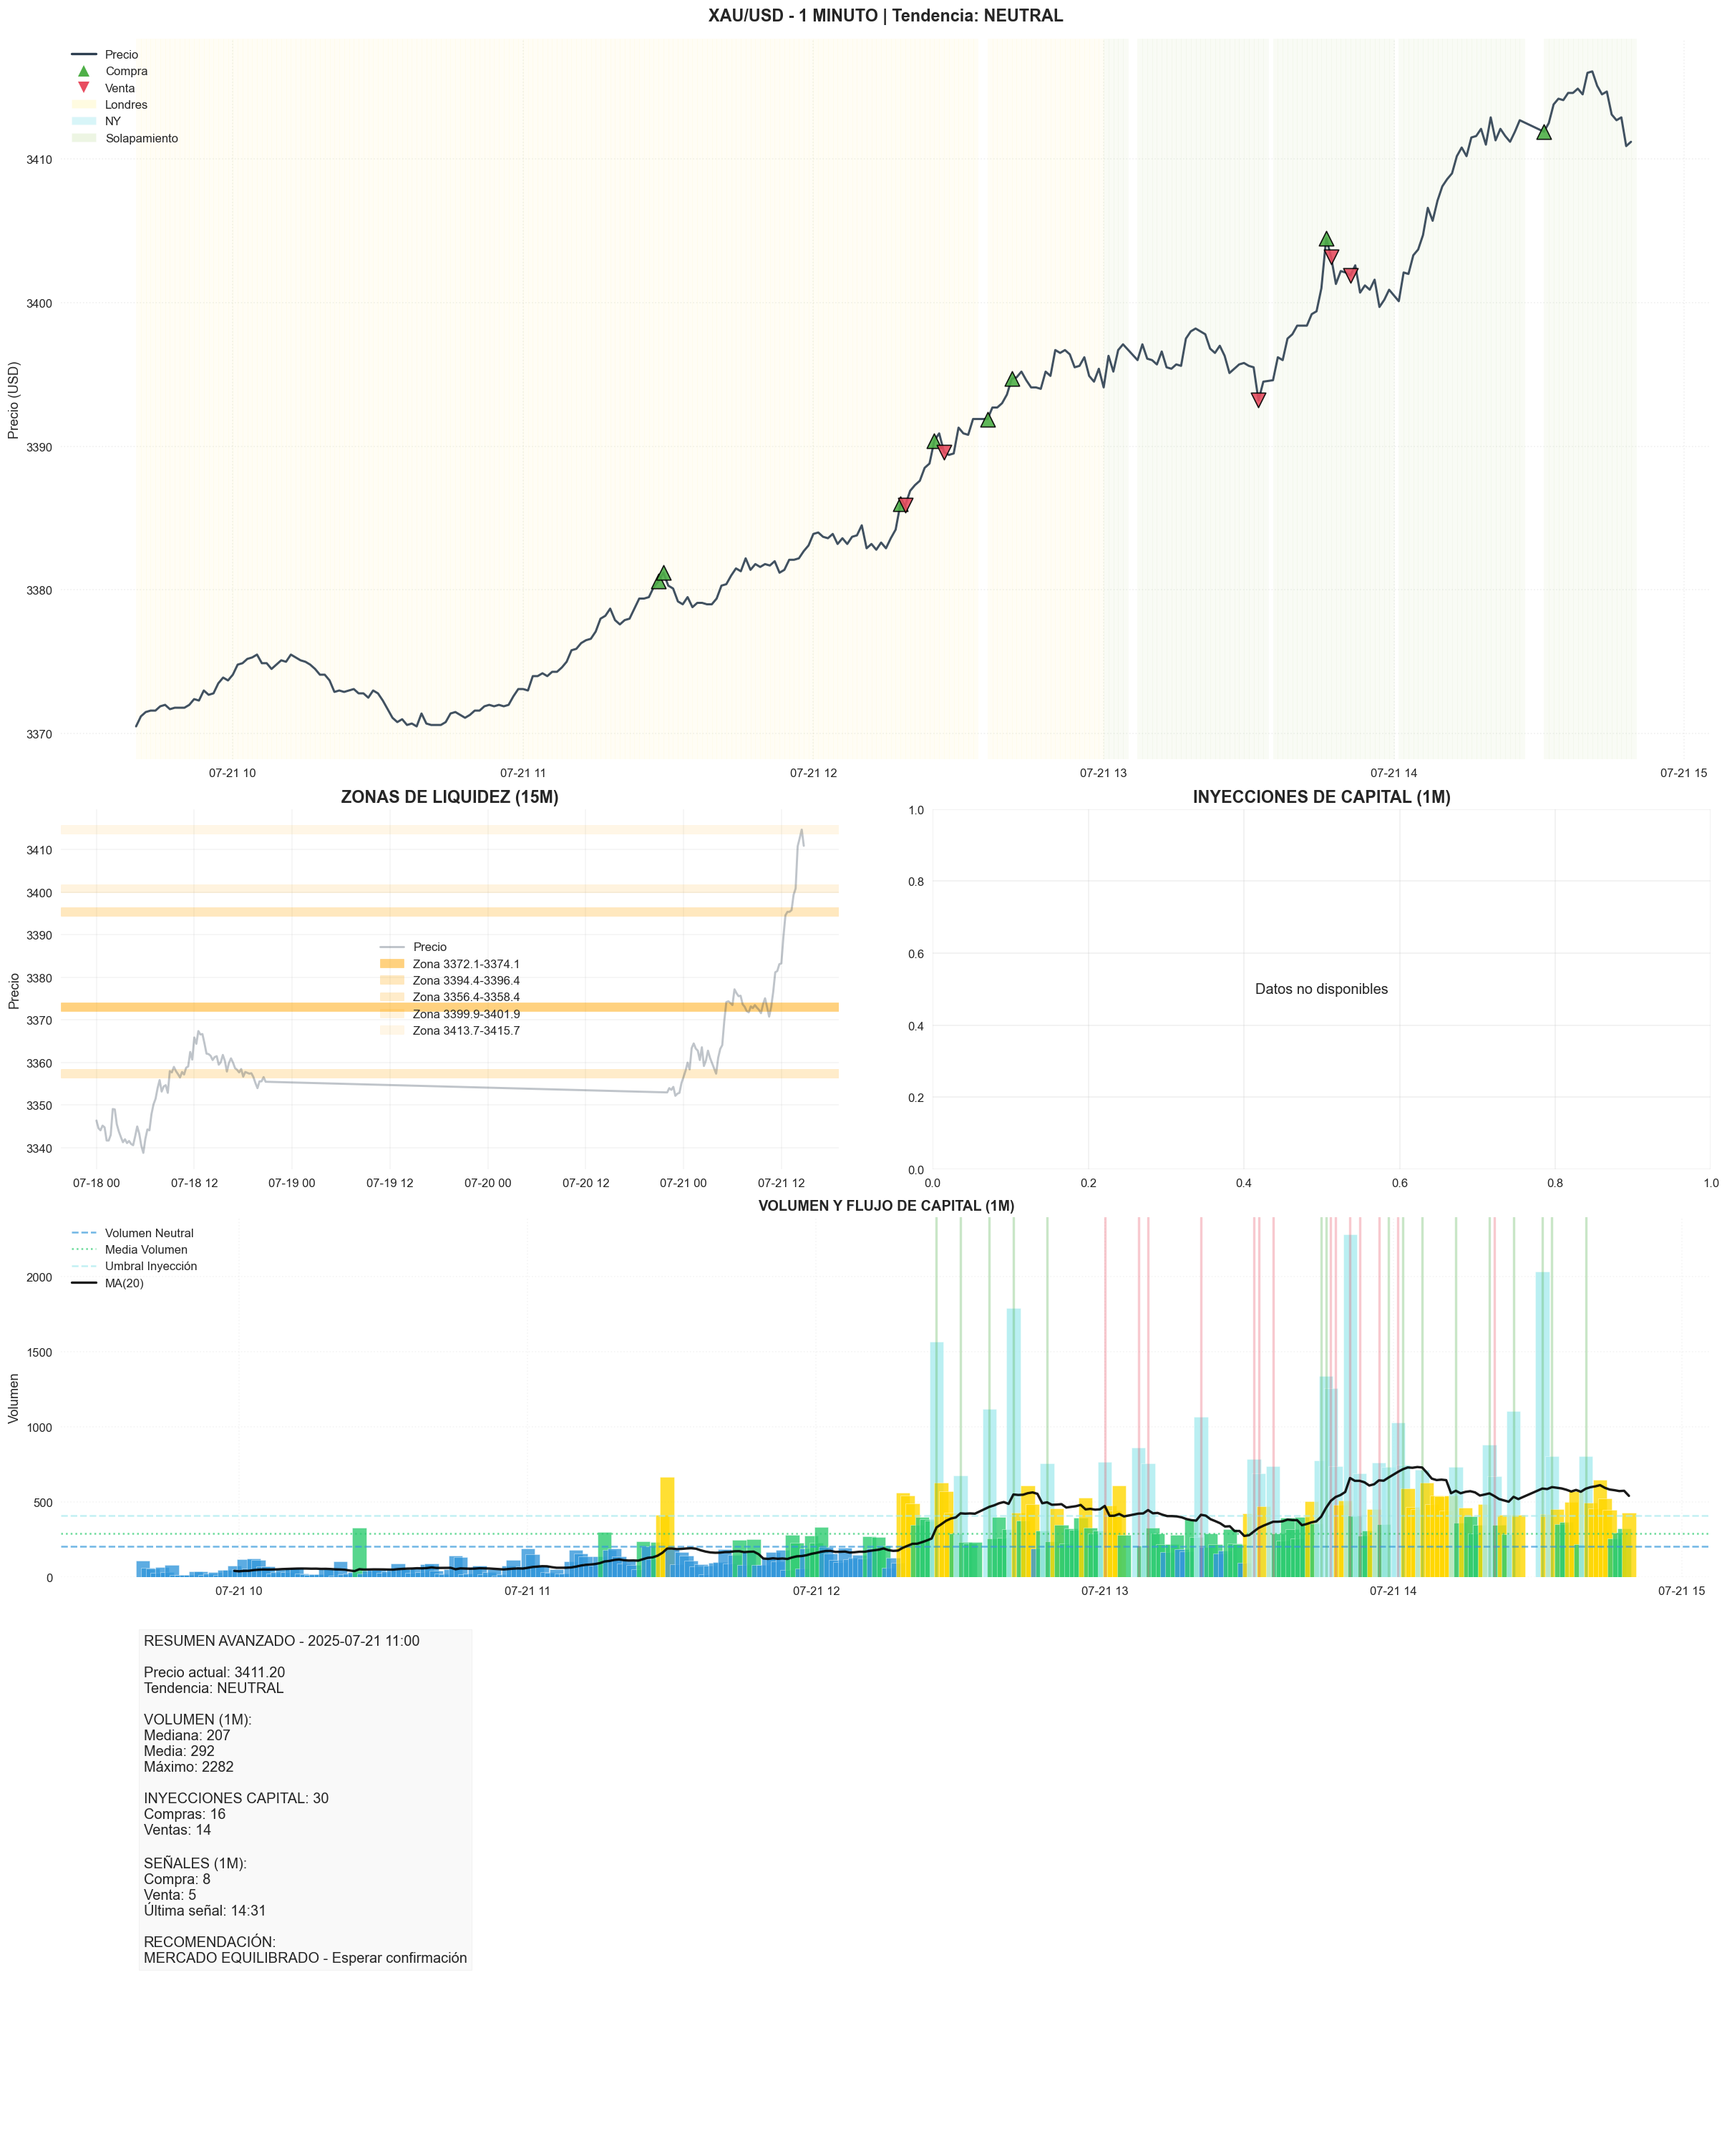


✅ Análisis completado correctamente


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta, time
from scipy import stats
import math

# Configuración visual profesional
plt.style.use('seaborn-v0_8')
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (20, 25),
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold'
})

# Paleta de colores optimizada
COLORS = {
    'venta': "#E84D60",     # Rojo
    'compra': "#4EAF47",      # Verde
    'vol_alto': "#FFD700",   # Amarillo oro
    'precio': "#2C3E50",     # Gris oscuro
    'tendencia_alcista': "#1f77b4",
    'tendencia_bajista': "#d62728",
    'fondo': "#f7f7f7",
    'london_session': "#FFF59D",
    'ny_session': "#80DEEA",
    'overlap_session': "#C5E1A5",
    'neutral_price': "#7E57C2",
    'zona_liquidez': "#FFA500",
    'vol_neutral': "#3498db", # Azul para volumen neutral
    'vol_medio': "#2ecc71",   # Verde para volumen medio
    'vol_fuerte': "#A9EBEF"   # Rojo para volumen fuerte
}

class AnalisisXAUUSD:
    def __init__(self):
        self.symbol = "GC=F"
        self.timeframes = {
            '1M': "1m",
            '15M': "15m"
        }
        
        # Parámetros optimizados
        self.anomaly_threshold = 2.8
        self.volume_multiplier = 2.0
        self.trend_volume_threshold = 1.5
        self.liquidity_volume_threshold = 2.0
        self.capital_injection_threshold = 0.5  # 0.5% de movimiento
        
        # Horarios de liquidez (GMT)
        self.london_open = time(8, 0)
        self.london_close = time(17, 0)
        self.ny_open = time(13, 0)
        self.ny_close = time(18, 0)
        
        print("🔄 Inicializando análisis XAU/USD profesional...")
        print(f"📊 Temporalidades: {list(self.timeframes.keys())}")

    def detect_trend_by_volume(self, df):
        """Determina la tendencia basada en volumen significativo"""
        high_volume = df[df['volume'] > self.trend_volume_threshold * df['volume'].median()]
        
        if len(high_volume) < 5:
            return 'neutral'
        
        buy_ratio = len(high_volume[high_volume['close'] > high_volume['open']]) / len(high_volume)
        
        if buy_ratio > 0.65:
            return 'alcista'
        elif buy_ratio < 0.35:
            return 'bajista'
        else:
            return 'neutral'

    def is_liquid_session(self, dt):
        """Determina si es horario de alta liquidez"""
        dt_time = dt.time()
        return (self.london_open <= dt_time <= self.london_close) or \
               (self.ny_open <= dt_time <= self.ny_close)

    def get_data(self, timeframe, count):
        """Obtiene y procesa datos de mercado"""
        try:
            period_map = {'1m': '7d', '15m': '60d'}
            print(f"\n⏳ Descargando datos {timeframe}...")
            
            data = yf.download(
                tickers=self.symbol,
                period=period_map[timeframe],
                interval=timeframe,
                progress=False,
                auto_adjust=True
            )
            
            if data.empty:
                raise ValueError("No se recibieron datos")
                
            data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
            data.columns = ['open', 'high', 'low', 'close', 'volume']
            data.index.name = 'timestamp'
            
            data = data[data['volume'] > 0].iloc[-count:]
            data['returns'] = data['close'].pct_change()
            data['liquid_session'] = data.index.map(self.is_liquid_session)
            
            print(f"✅ Datos {timeframe} obtenidos: {len(data)} velas")
            return self.detect_anomalies(data)
            
        except Exception as e:
            print(f"⚠️ Error en datos reales: {str(e)}")
            return self.generate_simulated_data(timeframe, count)

    def generate_simulated_data(self, timeframe, count):
        """Genera datos simulados para pruebas"""
        np.random.seed(42)
        freq_map = {'1m': '1min', '15m': '15min'}
        dates = pd.date_range(end=pd.Timestamp.now(), periods=count, freq=freq_map[timeframe])
        
        base_price = 1800 + np.cumsum(np.random.randn(count) * 0.5)
        
        data = pd.DataFrame({
            'open': base_price,
            'high': base_price + np.abs(np.random.randn(count)) * 1.2,
            'low': base_price - np.abs(np.random.randn(count)) * 1.2,
            'close': base_price + np.random.randn(count) * 0.8,
            'volume': np.abs(np.random.normal(100, 30, count)).astype(int),
            'returns': np.zeros(count),
            'liquid_session': False
        }, index=dates)
        
        for i in range(len(data)):
            data.iloc[i, data.columns.get_loc('liquid_session')] = self.is_liquid_session(data.index[i])
            if data.iloc[i]['liquid_session']:
                data.iloc[i, data.columns.get_loc('volume')] = int(data.iloc[i]['volume'] * 1.8)
        
        data['returns'] = data['close'].pct_change()
        return data

    def detect_anomalies(self, df):
        """Detección de anomalías con filtros mejorados"""
        df['vol_mean'] = df['volume'].rolling(50, min_periods=10).mean()
        df['vol_std'] = df['volume'].rolling(50, min_periods=10).std()
        df['vol_z'] = (df['volume'] - df['vol_mean']) / (df['vol_std'] + 1e-6)
        
        returns = df['returns']
        median = returns.rolling(50, min_periods=10).median()
        mad = 1.4826 * np.abs(returns - median).rolling(50, min_periods=10).median()
        df['ret_z'] = (returns - median) / (mad + 1e-6)
        
        df['liquidity_ok'] = df['volume'] > df['volume'].quantile(0.7)
        
        df['anomaly'] = (
            ((np.abs(df['vol_z']) > self.anomaly_threshold) |
            (np.abs(df['ret_z']) > self.anomaly_threshold)) &
            df['liquidity_ok']
        )
        
        conditions = [
            (df['close'] > df['open']) & df['anomaly'],
            (df['close'] < df['open']) & df['anomaly']
        ]
        choices = ['compra', 'venta']
        df['anomaly_type'] = np.select(conditions, choices, default=None)
        
        return df

    def calculate_capital_injections(self, df):
        """Identifica inyecciones fuertes de capital"""
        # Niveles dinámicos de volumen
        vol_median = df['volume'].median()
        vol_q75 = df['volume'].quantile(0.75)
        vol_q90 = df['volume'].quantile(0.90)
        
        # Movimiento de precio significativo
        df['price_move'] = (df['high'] - df['low']) / df['close'] * 100
        
        # Condiciones para inyecciones
        df['inyeccion_fuerte'] = (
            (df['volume'] > vol_q90) | 
            ((df['volume'] > vol_q75) & (df['price_move'] > self.capital_injection_threshold))
        )
        
        # Dirección de la inyección
        df['tipo_inyeccion'] = np.where(
            df['inyeccion_fuerte'] & (df['close'] > df['open']),
            'compra',
            np.where(
                df['inyeccion_fuerte'] & (df['close'] < df['open']),
                'venta',
                None
            )
        )
        
        # Clasificación de volumen
        df['nivel_volumen'] = np.where(
            df['volume'] > vol_q75, 'fuerte',
            np.where(
                df['volume'] > vol_median, 'medio',
                'neutral'
            )
        )
        
        return df

    def calculate_liquidity_zones(self, df):
        """Identifica zonas de liquidez significativas"""
        df['price_level'] = df['close'].round(1)
        liquidity = df.groupby('price_level').agg({
            'volume': 'sum',
            'close': 'count',
            'high': 'max',
            'low': 'min'
        }).sort_values('volume', ascending=False)
        
        significant_zones = liquidity[liquidity['volume'] > self.liquidity_volume_threshold * df['volume'].mean()]
        
        zones = []
        for level in significant_zones.index:
            if not zones:
                zones.append({'min': level-1, 'max': level+1, 'volume': significant_zones.loc[level, 'volume']})
            else:
                added = False
                for zone in zones:
                    if zone['min'] <= level <= zone['max']:
                        zone['volume'] += significant_zones.loc[level, 'volume']
                        added = True
                        break
                if not added:
                    zones.append({'min': level-1, 'max': level+1, 'volume': significant_zones.loc[level, 'volume']})
        
        return sorted(zones, key=lambda x: x['volume'], reverse=True)

    def calculate_log_performance(self, df):
        """Calcula el rendimiento logarítmico"""
        df['ema_200'] = df['close'].ewm(span=200, adjust=False).mean()
        df['log_return'] = np.log(df['close'] / df['ema_200'])
        
        mean_log = df['log_return'].mean()
        std_log = df['log_return'].std()
        df['upper_band'] = mean_log + 2 * std_log
        df['lower_band'] = mean_log - 2 * std_log
        df['anomaly_log'] = (df['log_return'] > df['upper_band']) | (df['log_return'] < df['lower_band'])
        
        return df

    def _plot_volume_trend(self, ax, data, title):
        """Gráfico avanzado de volumen con inyecciones de capital"""
        # Calcular niveles dinámicos
        vol_median = data['volume'].median()
        vol_mean = data['volume'].mean()
        vol_q75 = data['volume'].quantile(0.75)
        vol_q90 = data['volume'].quantile(0.90)
        
        # Colores según nivel e inyección
        colors = []
        for idx, row in data.iterrows():
            if row['volume'] > vol_q90:
                colors.append(COLORS['vol_fuerte'])
            elif row['volume'] > vol_q75:
                colors.append(COLORS['vol_alto'])
            elif row['volume'] > vol_median:
                colors.append(COLORS['vol_medio'])
            else:
                colors.append(COLORS['vol_neutral'])
        
        # Barras de volumen
        bars = ax.bar(data.index, data['volume'], color=colors, width=0.002, alpha=0.8)
        
        # Líneas de referencia
        ax.axhline(vol_median, color=COLORS['vol_neutral'], linestyle='--', linewidth=1.5, alpha=0.7, label='Volumen Neutral')
        ax.axhline(vol_mean, color=COLORS['vol_medio'], linestyle=':', linewidth=1.5, alpha=0.7, label='Media Volumen')
        ax.axhline(vol_q75, color=COLORS['vol_fuerte'], linestyle='--', linewidth=1.5, alpha=0.7, label='Umbral Inyección')
        
        # Resaltar inyecciones
        if 'tipo_inyeccion' in data.columns:
            inyecciones = data[data['tipo_inyeccion'].notna()]
            for idx, row in inyecciones.iterrows():
                color = COLORS['compra'] if row['tipo_inyeccion'] == 'compra' else COLORS['venta']
                ax.axvline(x=idx, color=color, linestyle='-', alpha=0.3, linewidth=2)
        
        # Media móvil
        if len(data) > 20:
            ax.plot(data.index, data['volume'].rolling(20).mean(),
                   color='black', linewidth=2, alpha=0.9, label='MA(20)')
        
        # Configuración
        ax.set_title(title, fontsize=12)
        ax.set_ylabel('Volumen')
        ax.grid(True, linestyle=':', alpha=0.2)
        ax.legend(loc='upper left')

    def plot_liquidity_zones(self, ax, df, title):
        """Gráfico de zonas de liquidez"""
        zones = self.calculate_liquidity_zones(df)
        
        if not zones:
            ax.text(0.5, 0.5, "No hay zonas de liquidez significativas", ha='center', va='center')
            ax.set_title(title)
            return
        
        ax.plot(df.index, df['close'], color=COLORS['precio'], alpha=0.3, label='Precio')
        
        for zone in zones[:5]:
            ax.axhspan(zone['min'], zone['max'], 
                      color=COLORS['zona_liquidez'], 
                      alpha=0.5*(zone['volume']/zones[0]['volume']),
                      label=f'Zona {zone["min"]}-{zone["max"]}')
        
        ax.set_title(title)
        ax.set_ylabel('Precio')
        ax.legend()
        ax.grid(True, alpha=0.2)

    def plot_log_performance(self, ax, df, title):
        """Gráfico de rendimiento logarítmico"""
        if 'log_return' not in df.columns:
            ax.text(0.5, 0.5, "Datos no disponibles", ha='center', va='center')
            ax.set_title(title)
            return
        
        ax.plot(df.index, df['log_return'], color=COLORS['precio'], linewidth=1.5, label='Rendimiento')
        
        if 'inyeccion_compra' in df.columns:
            compras = df[df['inyeccion_compra']]
            if not compras.empty:
                ax.scatter(compras.index, compras['log_return'], 
                          color=COLORS['compra'], s=100,
                          label='Inyección Compra', marker='^')
        
        if 'inyeccion_venta' in df.columns:
            ventas = df[df['inyeccion_venta']]
            if not ventas.empty:
                ax.scatter(ventas.index, ventas['log_return'], 
                          color=COLORS['venta'], s=100,
                          label='Inyección Venta', marker='v')
        
        ax.axhline(0, color=COLORS['neutral_price'], linestyle='--', label='Neutral')
        ax.set_title(title)
        ax.set_ylabel('Log(Precio/EMA200)')
        ax.legend()
        ax.grid(True, alpha=0.2)

    def _plot_price_with_sessions(self, ax, data, title):
        """Gráfico de precio con sesiones"""
        for i in range(len(data)):
            dt = data.index[i]
            if self.london_open <= dt.time() <= self.london_close:
                if self.ny_open <= dt.time() <= self.ny_close:
                    ax.axvspan(dt, dt + timedelta(minutes=1), color=COLORS['overlap_session'], alpha=0.1)
                else:
                    ax.axvspan(dt, dt + timedelta(minutes=1), color=COLORS['london_session'], alpha=0.1)
            elif self.ny_open <= dt.time() <= self.ny_close:
                ax.axvspan(dt, dt + timedelta(minutes=1), color=COLORS['ny_session'], alpha=0.1)
        
        ax.plot(data.index, data['close'], color=COLORS['precio'], linewidth=1.8, alpha=0.9, label='Precio')
        
        if 'anomaly_type' in data.columns:
            anomalies = data[data['anomaly_type'].notna()]
            
            for idx, row in anomalies.iterrows():
                alpha = 0.9 if row['liquid_session'] else 0.3
                color = COLORS['compra'] if row['anomaly_type'] == "compra" else COLORS['venta']
                marker = '^' if row['anomaly_type'] == "compra" else 'v'
                
                ax.scatter(idx, row['close'], color=color, s=150, alpha=alpha,
                          marker=marker, edgecolors='black', linewidth=1, zorder=5)
        
        ax.set_title(title, pad=15, fontsize=14, fontweight='bold')
        ax.set_ylabel('Precio (USD)')
        ax.grid(True, linestyle=':', alpha=0.3)
        
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=COLORS['precio'], lw=2, label='Precio'),
            Line2D([0], [0], marker='^', color='w', label='Compra',
                  markerfacecolor=COLORS['compra'], markersize=10),
            Line2D([0], [0], marker='v', color='w', label='Venta',
                  markerfacecolor=COLORS['venta'], markersize=10),
            plt.Rectangle((0,0),1,1, fc=COLORS['london_session'], alpha=0.3, label='Londres'),
            plt.Rectangle((0,0),1,1, fc=COLORS['ny_session'], alpha=0.3, label='NY'),
            plt.Rectangle((0,0),1,1, fc=COLORS['overlap_session'], alpha=0.3, label='Solapamiento')
        ]
        ax.legend(handles=legend_elements, loc='upper left')

    def _plot_advanced_summary(self, ax, data_1m, data_15m, trend):
        """Resumen estadístico avanzado"""
        ax.axis('off')
        
        signals_1m = data_1m[data_1m['anomaly_type'].notna()]
        signals_15m = data_15m[data_15m['anomaly_type'].notna()]
        
        current_price = data_1m['close'].iloc[-1]
        last_signal = signals_1m.index[-1].strftime('%H:%M') if not signals_1m.empty else "Ninguna"
        
        # Estadísticas de volumen
        vol_stats = data_1m['volume'].describe()
        
        # Inyecciones de capital
        inyecciones = data_1m[data_1m['inyeccion_fuerte'] == True] if 'inyeccion_fuerte' in data_1m.columns else []
        
        summary_text = [
            f"RESUMEN AVANZADO - {datetime.now().strftime('%Y-%m-%d %H:%M')}",
            f"\nPrecio actual: {current_price:.2f}",
            f"Tendencia: {trend.upper()}",
            f"\nVOLUMEN (1M):",
            f"Mediana: {vol_stats['50%']:.0f}",
            f"Media: {vol_stats['mean']:.0f}",
            f"Máximo: {vol_stats['max']:.0f}",
            f"\nINYECCIONES CAPITAL: {len(inyecciones)}",
            f"Compras: {len(inyecciones[inyecciones['tipo_inyeccion'] == 'compra'])}",
            f"Ventas: {len(inyecciones[inyecciones['tipo_inyeccion'] == 'venta'])}",
            f"\nSEÑALES (1M):",
            f"Compra: {len(signals_1m[signals_1m['anomaly_type'] == 'compra'])}",
            f"Venta: {len(signals_1m[signals_1m['anomaly_type'] == 'venta'])}",
            f"Última señal: {last_signal}",
            f"\nRECOMENDACIÓN:",
            self._generate_recommendation(trend, signals_1m, signals_15m, inyecciones)
        ]
        
        ax.text(0.05, 0.95, "\n".join(summary_text), 
               ha='left', va='top', fontsize=12, 
               bbox=dict(facecolor=COLORS['fondo'], alpha=0.7, edgecolor='#dddddd'))

    def _generate_recommendation(self, trend, signals_1m, signals_15m, inyecciones):
        """Genera recomendación basada en múltiples factores"""
        buy_signals = len(signals_1m[signals_1m['anomaly_type'] == 'compra'])
        sell_signals = len(signals_1m[signals_1m['anomaly_type'] == 'venta'])
        
        buy_injections = len(inyecciones[inyecciones['tipo_inyeccion'] == 'compra']) if isinstance(inyecciones, pd.DataFrame) else 0
        sell_injections = len(inyecciones[inyecciones['tipo_inyeccion'] == 'venta']) if isinstance(inyecciones, pd.DataFrame) else 0
        
        if trend == 'alcista' and (buy_signals + buy_injections) > (sell_signals + sell_injections) * 1.5:
            return "FUERTE TENDENCIA ALCISTA - Buscar entradas largas"
        elif trend == 'bajista' and (sell_signals + sell_injections) > (buy_signals + buy_injections) * 1.5:
            return "FUERTE TENDENCIA BAJISTA - Buscar entradas cortas"
        elif (buy_injections > sell_injections * 2):
            return "FUERTE INYECCIÓN COMPRADORA - Considerar largas"
        elif (sell_injections > buy_injections * 2):
            return "FUERTE INYECCIÓN VENDEDORA - Considerar cortas"
        else:
            return "MERCADO EQUILIBRADO - Esperar confirmación"

    def plot_advanced_analysis(self):
        """Dashboard visual completo"""
        print("\n📊 Generando dashboard profesional...")
        
        data_1m = self.get_data('1m', 300)
        data_15m = self.get_data('15m', 150)
        
        data_1m = self.calculate_capital_injections(data_1m)
        data_15m = self.calculate_log_performance(data_15m)
        current_trend = self.detect_trend_by_volume(data_1m)
        
        fig = plt.figure(constrained_layout=True)
        gs = gridspec.GridSpec(4, 2, figure=fig, height_ratios=[2,1,1,1.5])
        
        ax1 = fig.add_subplot(gs[0, :])
        self._plot_price_with_sessions(ax1, data_1m, f"XAU/USD - 1 MINUTO | Tendencia: {current_trend.upper()}")
        
        ax2 = fig.add_subplot(gs[1, 0])
        self.plot_liquidity_zones(ax2, data_15m, "ZONAS DE LIQUIDEZ (15M)")
        
        ax3 = fig.add_subplot(gs[1, 1])
        self.plot_log_performance(ax3, data_1m, "INYECCIONES DE CAPITAL (1M)")
        
        ax4 = fig.add_subplot(gs[2, :])
        self._plot_volume_trend(ax4, data_1m, "VOLUMEN Y FLUJO DE CAPITAL (1M)")
        
        ax5 = fig.add_subplot(gs[3, :])
        self._plot_advanced_summary(ax5, data_1m, data_15m, current_trend)
        
        plt.show()
        print("\n✅ Análisis completado correctamente")

    def run(self):
        """Método principal de ejecución"""
        
        print("="*70)
        print("ANÁLISIS INSTITUCIONAL XAU/USD".center(70))
        print("="*70)
        print(f"🔍 Símbolo: {self.symbol}")
        print(f"⏱️  Temporalidades: {', '.join(self.timeframes.keys())}")
        print(f"⚙️  Parámetros:")
        print(f"   - Sensibilidad anomalías: Z > {self.anomaly_threshold}")
        print(f"   - Umbral inyección capital: {self.capital_injection_threshold}%")
        
        input("\nPresiona Enter para generar el análisis...")
        self.plot_advanced_analysis()

# Ejecución del análisis
analyzer = AnalisisXAUUSD()
analyzer.run()